In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.optimize as fit
from datetime import datetime
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [2]:
# Importing and adjusting the data

In [3]:
muon002 = pd.read_csv('Muon002.csv', nrows=400, usecols=['Date', 'Mu2Ch12', 'Mu2Ch13', 'Mu2Ch23'])
# Only using columns that are not normalized for pressure
# Data records number of muon instances over the hours, already filtered by coincidence

In [4]:
muon002 = muon002.rename(columns={'Mu2Ch12': 'Layer12', 'Mu2Ch13': 'Layer13', 'Mu2Ch23': 'Layer23'})
# Renamed for clarity

In [5]:
muon002.head()

,Date,Layer12,Layer13,Layer23
0,2022-06-24 03:00:00+00:00,19564,10121,20360
1,2022-06-24 04:00:00+00:00,19499,10149,20460
2,2022-06-24 05:00:00+00:00,19230,9870,20169
3,2022-06-24 06:00:00+00:00,19763,10296,20388
4,2022-06-24 07:00:00+00:00,19555,10161,20375


In [6]:
pressure_table = pd.read_csv('CQT.csv', nrows = 400, skiprows=[1, 2, 3])
# First 3 rows are skipped to account for the fact that muon detection starts recording at 3:00am
# Note: mslp = Mean Level Sea Pressure, pressure normalized from height deviations, in mbar

In [7]:
pressure_table.head()

,station,time,mslp
0,CQT,6/24/2022 3:47,1010.6
1,CQT,6/24/2022 4:47,1010.9
2,CQT,6/24/2022 5:47,1010.9
3,CQT,6/24/2022 6:47,1011.3
4,CQT,6/24/2022 7:47,1011.3


In [8]:
pressure_table = pressure_table.rename(columns={'time': 'Date'})
pressure_table = pressure_table[pressure_table['Date'].str.endswith('47')]
pressure_table['Date'] = pressure_table['Date'].str.replace(':47', ':00', regex=False)
# Normalizing the times, measures pressure for each hour

In [9]:
# function that converts datetime to match
def convert_date(series):
    """
    Converts a pandas Series of datetime strings from 'M/D/YYYY H:MM' format
    to 'YYYY-MM-DD HH:MM:SS+00:00' format.
    """
    # Parse the Series into datetime objects
    dt_series = pd.to_datetime(series, format="%m/%d/%Y %H:%M", utc = True)
    # Format the datetime objects into the desired UTC string format
    return dt_series.dt.strftime("%Y-%m-%d %H:%M:%S+00:00")

In [10]:
pressure_table['Date'] = convert_date(pressure_table['Date'])

In [11]:
pressure_table['Date']

0      2022-06-24 03:00:00+00:00
1      2022-06-24 04:00:00+00:00
2      2022-06-24 05:00:00+00:00
3      2022-06-24 06:00:00+00:00
4      2022-06-24 07:00:00+00:00
                 ...            
392    2022-07-08 12:00:00+00:00
394    2022-07-08 13:00:00+00:00
395    2022-07-08 14:00:00+00:00
397    2022-07-08 15:00:00+00:00
399    2022-07-08 16:00:00+00:00
Name: Date, Length: 350, dtype: object

In [12]:
# merge two dataframes together to match datetime
muon = pd.merge(muon002, pressure_table, on = 'Date')
muon = muon.drop(columns=['station']) # unecessary column

In [13]:
muon

,Date,Layer12,Layer13,Layer23,mslp
0,2022-06-24 03:00:00+00:00,19564,10121,20360,1010.6
1,2022-06-24 04:00:00+00:00,19499,10149,20460,1010.9
2,2022-06-24 05:00:00+00:00,19230,9870,20169,1010.9
3,2022-06-24 06:00:00+00:00,19763,10296,20388,1011.3
4,2022-06-24 07:00:00+00:00,19555,10161,20375,1011.3
...,...,...,...,...,...
345,2022-07-08 12:00:00+00:00,19754,10302,20606,1016.0
346,2022-07-08 13:00:00+00:00,19864,10283,20629,1016.3
347,2022-07-08 14:00:00+00:00,19476,9998,20316,1016.8
348,2022-07-08 15:00:00+00:00,19807,10332,20759,1016.9


In [14]:
# Actual project computation

In [15]:
# Computing the average pressure over the entire time period
average_pressure = muon['mslp'].mean()
print(average_pressure)

1013.6197142857144


In [16]:
# Adding delta P column
muon['delta_p'] = muon['mslp'] - average_pressure
muon['delta_p']

0     -3.019714
1     -2.719714
2     -2.719714
3     -2.319714
4     -2.319714
         ...   
345    2.380286
346    2.680286
347    3.180286
348    3.280286
349    3.180286
Name: delta_p, Length: 350, dtype: float64

In [17]:
# Computing Count Rates and Flux
muon['Layer12Rate'] = muon['Layer12']/60 # counts per minute
muon['Layer13Rate'] = muon['Layer13']/60
muon['Layer23Rate'] = muon['Layer23']/60

muon['Layer12Flux'] = muon['Layer12Rate']/400 # counts per square cm per minute
muon['Layer13Flux'] = muon['Layer13Rate']/400
muon['Layer23Flux'] = muon['Layer23Rate']/400

In [18]:
muon

,Date,Layer12,Layer13,Layer23,mslp,delta_p,Layer12Rate,Layer13Rate,Layer23Rate,Layer12Flux,Layer13Flux,Layer23Flux
0,2022-06-24 03:00:00+00:00,19564,10121,20360,1010.6,-3.019714,326.066667,168.683333,339.333333,0.815167,0.421708,0.848333
1,2022-06-24 04:00:00+00:00,19499,10149,20460,1010.9,-2.719714,324.983333,169.150000,341.000000,0.812458,0.422875,0.852500
2,2022-06-24 05:00:00+00:00,19230,9870,20169,1010.9,-2.719714,320.500000,164.500000,336.150000,0.801250,0.411250,0.840375
3,2022-06-24 06:00:00+00:00,19763,10296,20388,1011.3,-2.319714,329.383333,171.600000,339.800000,0.823458,0.429000,0.849500
4,2022-06-24 07:00:00+00:00,19555,10161,20375,1011.3,-2.319714,325.916667,169.350000,339.583333,0.814792,0.423375,0.848958
...,...,...,...,...,...,...,...,...,...,...,...,...
345,2022-07-08 12:00:00+00:00,19754,10302,20606,1016.0,2.380286,329.233333,171.700000,343.433333,0.823083,0.429250,0.858583
346,2022-07-08 13:00:00+00:00,19864,10283,20629,1016.3,2.680286,331.066667,171.383333,343.816667,0.827667,0.428458,0.859542
347,2022-07-08 14:00:00+00:00,19476,9998,20316,1016.8,3.180286,324.600000,166.633333,338.600000,0.811500,0.416583,0.846500
348,2022-07-08 15:00:00+00:00,19807,10332,20759,1016.9,3.280286,330.116667,172.200000,345.983333,0.825292,0.430500,0.864958


In [19]:
# Flux rates should be about 1 count/cm/min, slightly lower due to not all muons being detected and temperature variations
# 
# Layer 13 (coincidence mode between layers 1 and 3) are noticably lower bc layers 1 and 3 are seperated by a layer, 
# muons are less likely to trigger both
# 
# Calculating flux/intensity is not necessary for actually computing the barometric coefficient because units cancel when you just use rates,
# but its nice to confirm that our flux rates are somewhat close to the average

In [20]:
# Computing percent change in flux
average_flux_12 = muon['Layer12Flux'].mean()
average_flux_13 = muon['Layer13Flux'].mean()
average_flux_23 = muon['Layer23Flux'].mean()

muon['Layer12%Change'] = (muon['Layer12Flux'] - average_flux_12)/average_flux_12*100 # This is a signed percentage
muon['Layer13%Change'] = (muon['Layer13Flux'] - average_flux_13)/average_flux_13*100
muon['Layer23%Change'] = (muon['Layer23Flux'] - average_flux_23)/average_flux_23*100

In [21]:
muon

,Date,Layer12,Layer13,Layer23,mslp,delta_p,Layer12Rate,Layer13Rate,Layer23Rate,Layer12Flux,Layer13Flux,Layer23Flux,Layer12%Change,Layer13%Change,Layer23%Change
0,2022-06-24 03:00:00+00:00,19564,10121,20360,1010.6,-3.019714,326.066667,168.683333,339.333333,0.815167,0.421708,0.848333,0.122766,0.096470,-0.063516
1,2022-06-24 04:00:00+00:00,19499,10149,20460,1010.9,-2.719714,324.983333,169.150000,341.000000,0.812458,0.422875,0.852500,-0.209884,0.373389,0.427332
2,2022-06-24 05:00:00+00:00,19230,9870,20169,1010.9,-2.719714,320.500000,164.500000,336.150000,0.801250,0.411250,0.840375,-1.586547,-2.385915,-1.001034
3,2022-06-24 06:00:00+00:00,19763,10296,20388,1011.3,-2.319714,329.383333,171.600000,339.800000,0.823458,0.429000,0.849500,1.141190,1.827216,0.073922
4,2022-06-24 07:00:00+00:00,19555,10161,20375,1011.3,-2.319714,325.916667,169.350000,339.583333,0.814792,0.423375,0.848958,0.076707,0.492069,0.010111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,2022-07-08 12:00:00+00:00,19754,10302,20606,1016.0,2.380286,329.233333,171.700000,343.433333,0.823083,0.429250,0.858583,1.095130,1.886556,1.143968
346,2022-07-08 13:00:00+00:00,19864,10283,20629,1016.3,2.680286,331.066667,171.383333,343.816667,0.827667,0.428458,0.859542,1.658078,1.698646,1.256863
347,2022-07-08 14:00:00+00:00,19476,9998,20316,1016.8,3.180286,324.600000,166.633333,338.600000,0.811500,0.416583,0.846500,-0.327592,-1.119998,-0.279488
348,2022-07-08 15:00:00+00:00,19807,10332,20759,1016.9,3.280286,330.116667,172.200000,345.983333,0.825292,0.430500,0.864958,1.366369,2.183255,1.894965


In [22]:
# Plotting things

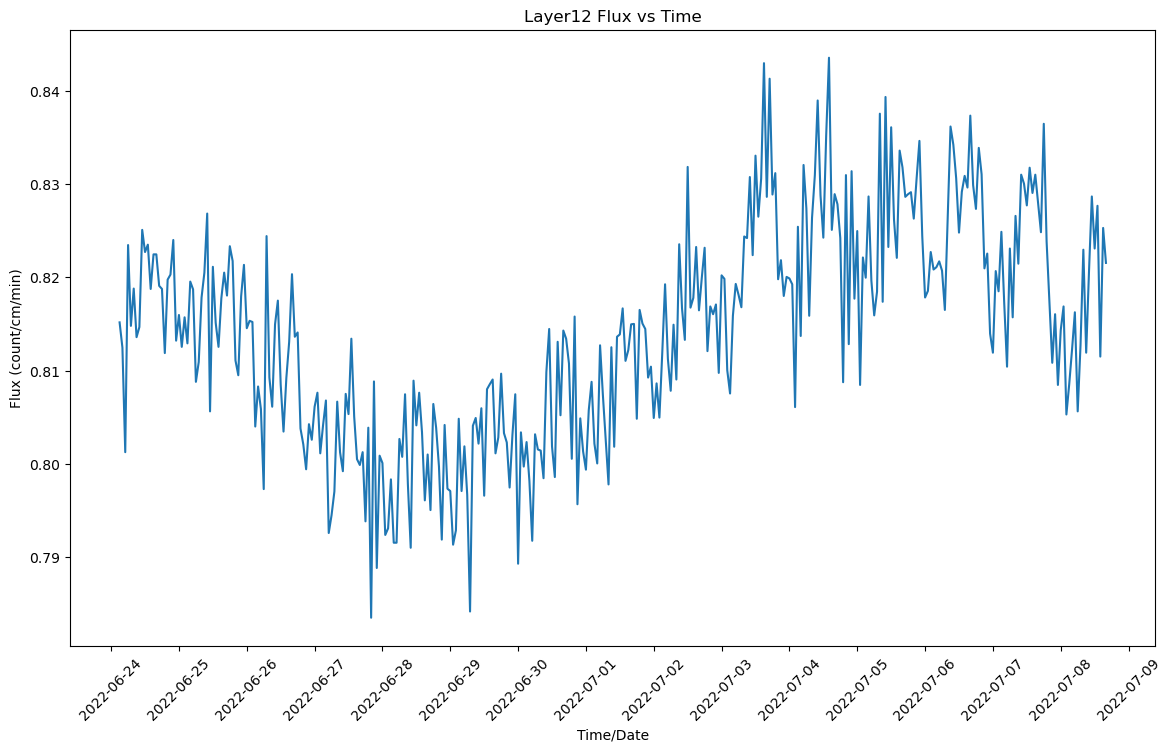

In [23]:
plt.figure(figsize=(14,8))
plt.title('Layer12 Flux vs Time')

plt.xlabel('Time/Date')
plt.ylabel('Flux (count/cm/min)')

plt.plot(pd.to_datetime(muon['Date']), muon['Layer12Flux'])
# Datetime pandas function converts the date into a format the mdates function can read

plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Tick every day
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
# Uses mdates function to locate the ticks that denote each day 12:00AM, and reformat what the ticks look like to shorten them

plt.show()

# This graph just shows a general trend for the Layer 12 flux, in order to see it's relationship to pressure we have to normalize
# the values relative to the each other

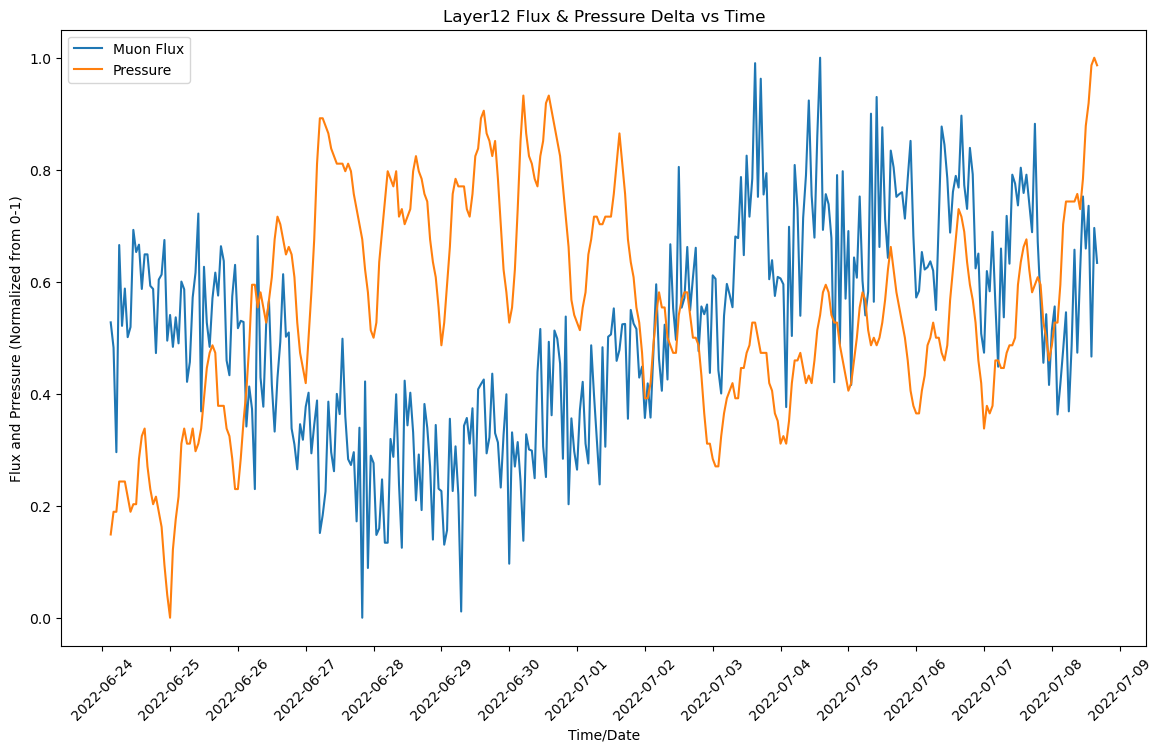

In [24]:
plt.figure(figsize=(14,8))
plt.title('Layer12 Flux & Pressure Delta vs Time')

plt.xlabel('Time/Date')
plt.ylabel('Flux and Prressure (Normalized from 0-1)')

plt.plot(pd.to_datetime(muon['Date']), scaler.fit_transform(muon[['Layer12Flux']]), label='Muon Flux')
plt.plot(pd.to_datetime(muon['Date']), scaler.fit_transform(muon[['delta_p']]), label='Pressure')
# Scaler.fit_transform is what normalizes everything

plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Tick every day
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.legend()
plt.show()
# From here we can see that pressure generally has a negative relationship with muon flux, so we know the barometric coefficient has to be negative.

In [25]:
# Solving for the barometric coefficient
# Defining our fit line
def f(x, m, b):
    return m * x + b
p0 = [-0.3, 4]

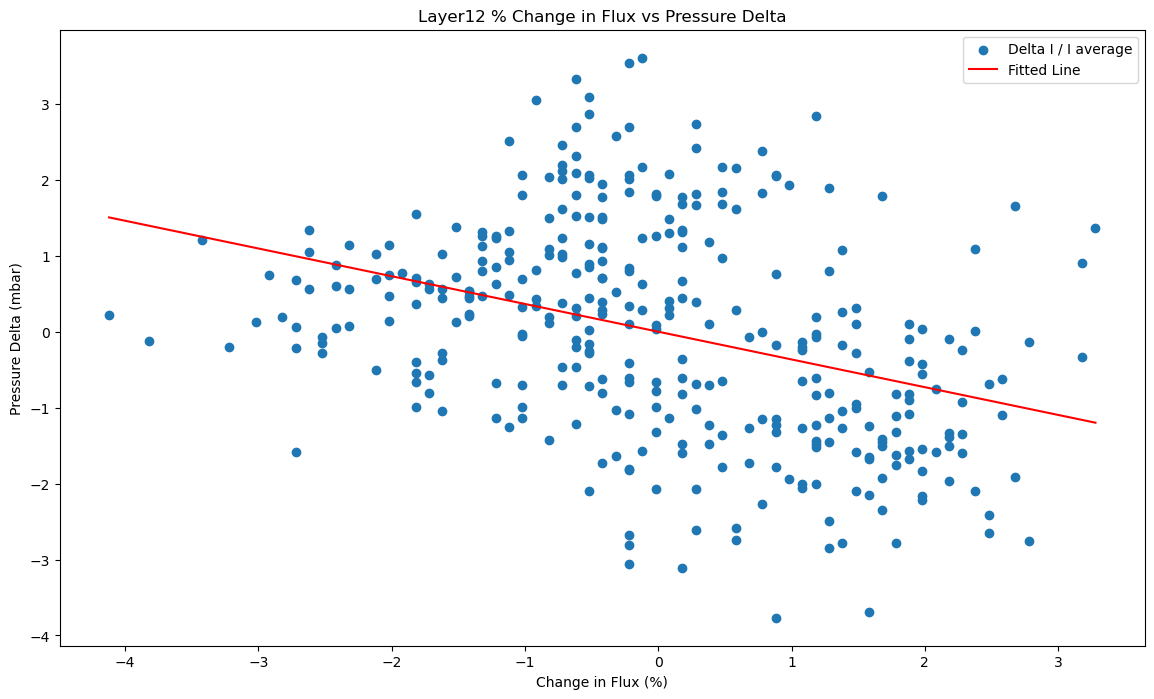

In [26]:
# Computing barometric coefficient for Layer 12
parameters_12, cv_matrix_12 = fit.curve_fit(f, muon['delta_p'], muon['Layer12%Change'], p0)

plt.figure(figsize=(14,8))
plt.title('Layer12 % Change in Flux vs Pressure Delta')

plt.xlabel('Change in Flux (%)')
plt.ylabel('Pressure Delta (mbar)')

x_axis = np.linspace(muon['delta_p'].min(), muon['delta_p'].max(), 100)
plt.scatter(muon['delta_p'], muon['Layer12%Change'], label = 'Delta I / I average')
plt.plot(x_axis, f(x_axis, parameters_12[0], parameters_12[1]), label = 'Fitted Line', color='red')

plt.legend()
plt.show()

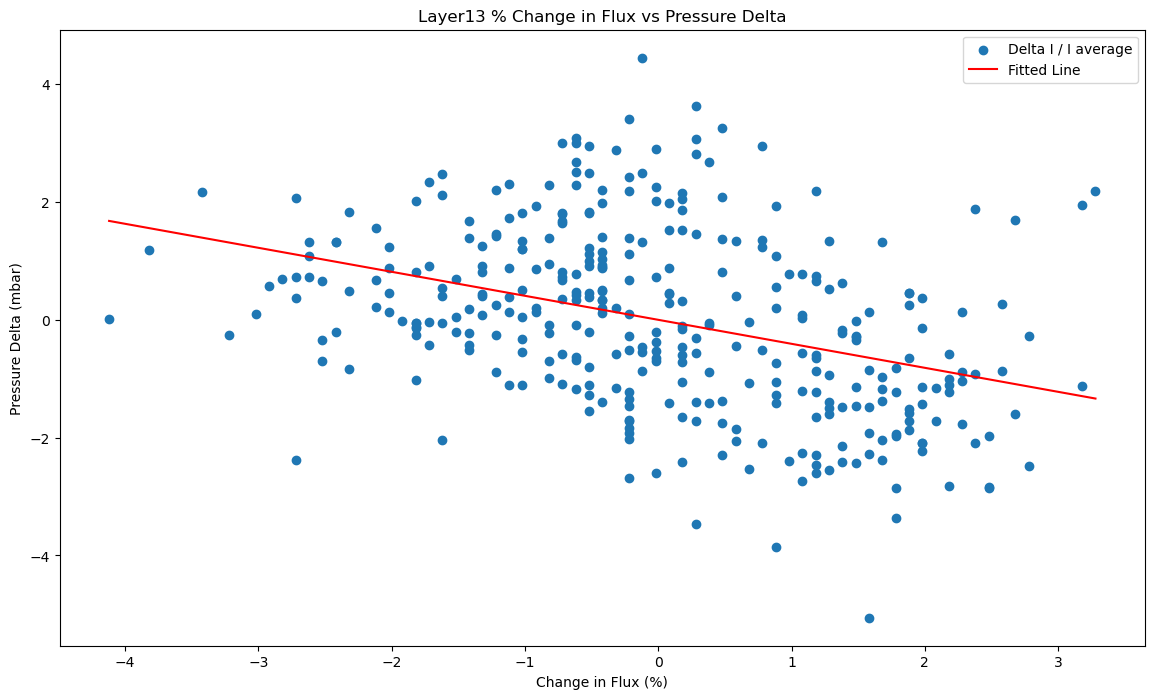

In [27]:
# Solving for the barometric coefficient using Layer 13
parameters_13, cv_matrix_13 = fit.curve_fit(f, muon['delta_p'], muon['Layer13%Change'], p0)

plt.figure(figsize=(14,8))
plt.title('Layer13 % Change in Flux vs Pressure Delta')

plt.xlabel('Change in Flux (%)')
plt.ylabel('Pressure Delta (mbar)')

plt.scatter(muon['delta_p'], muon['Layer13%Change'], label = 'Delta I / I average')
plt.plot(x_axis, f(x_axis, parameters_13[0], parameters_13[1]), label = 'Fitted Line', color='red')

plt.legend()
plt.show()

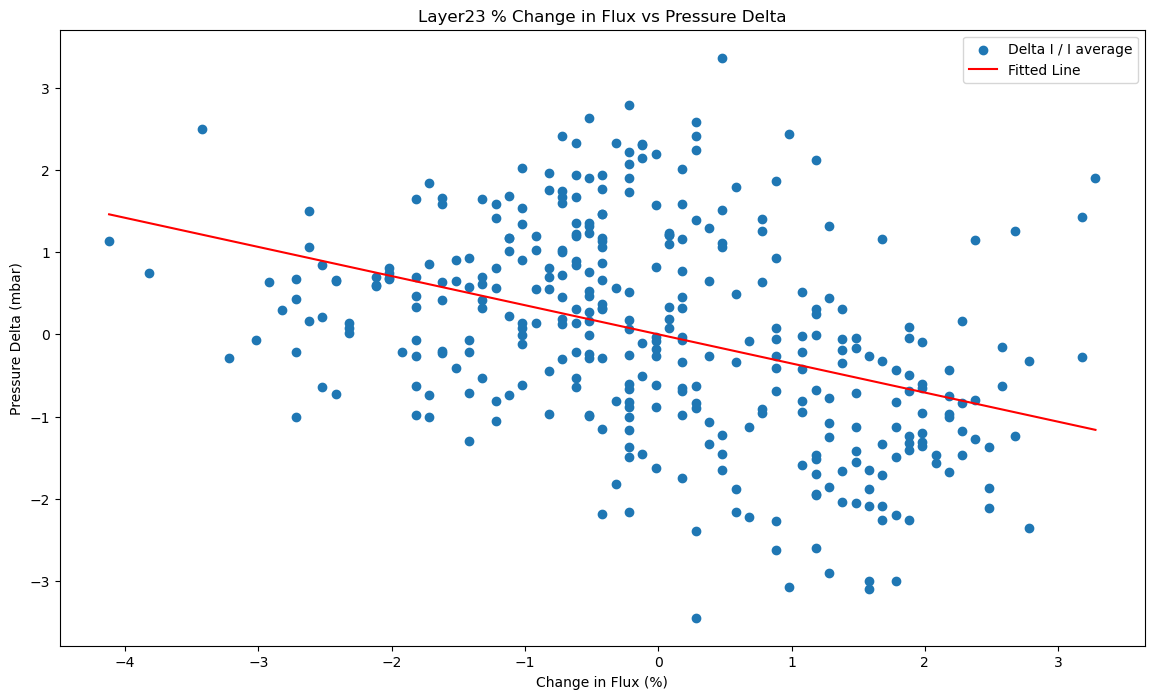

In [28]:
# Solving for the barometric coefficient using Layer 23
parameters_23, cv_matrix_23 = fit.curve_fit(f, muon['delta_p'], muon['Layer23%Change'], p0)

plt.figure(figsize=(14,8))
plt.title('Layer23 % Change in Flux vs Pressure Delta')

plt.xlabel('Change in Flux (%)')
plt.ylabel('Pressure Delta (mbar)')

plt.scatter(muon['delta_p'], muon['Layer23%Change'], label = 'Delta I / I average')
plt.plot(x_axis, f(x_axis, parameters_23[0], parameters_23[1]), label = 'Fitted Line', color='red')

plt.legend()
plt.show()

In [29]:
# Making a dataframe with all of our results
my_dict = {
    'Layer12': [parameters_12[0], cv_matrix_12[0,0]],
    'Layer13': [parameters_13[0], cv_matrix_13[0,0]],
    'Layer23': [parameters_23[0], cv_matrix_23[0,0]],
}

results = pd.DataFrame.from_dict(my_dict, orient='index', columns=['Coefficient', 'Error'])

In [30]:
results

,Coefficient,Error
Layer12,-0.365307,0.002515
Layer13,-0.407395,0.002841
Layer23,-0.354104,0.001963
